In [1]:
#Importing some standard python packages
#
import matplotlib as mpl
import sys
import matplotlib.pyplot as plt
import numpy as np
import xspec as xs

In [2]:
# Importing energy arrays observed with GRB 130305A, all given in MeV

E_GBM1 = np.load('130305A_GBM1_EMeV.npy')
E_GBM2 = np.load('130305A_GBM2_EMeV.npy')
E_BGO = np.load('130305A_BGO_EMeV.npy')
E_LLE = np.load('130305A_LLE_EMeV.npy')

In [3]:
# quick check of units
print E_LLE

[1.10113223e+01 1.32385210e+01 1.59162026e+01 1.91354844e+01
 2.30059131e+01 3.07133350e+01 6.37544453e+01 4.61482418e+02
 4.20876987e+03 3.83844360e+04 8.45915480e+04]


In [4]:
# Interpolating the function for the ALP signal to be given to XSPEC (Milena)

energy = np.concatenate((E_GBM1, E_GBM2, E_BGO, E_LLE)) # MeV
energy = np.unique(np.sort(energy))
low_lim = np.int(np.where(E_LLE[0] == energy)[0])

sys.path.append('/Users/milena/Desktop/2nd_yr_project/ALPs/ALPs_analysis/') # path to calc_alp_signal script
from scipy import integrate
from calc_alp_signal import ALPSNSignal

alp_sn = ALPSNSignal(Mprog = 10.)
ts = np.linspace(0.1,10.,len(energy) + 1)
dndedt_alp = alp_sn(energy, ts, g10=0.1)
SED = integrate.simps(dndedt_alp, axis=1)/10. # per MeV

from scipy.interpolate import interp1d

# interpolation attempt (Milena)
f = interp1d(energy*1000, SED/1000., 'cubic', fill_value="extrapolate") # in keV and per keV

In [5]:
# Interpolating the function for the ALP signal to be given to XSPEC (Manuel)

energy_new = np.logspace(np.log10(energy.min()), np.log10(energy.max()), energy.size) # changing the binning of the input energy
dndedt_alp_new = alp_sn(energy_new, ts, g10=0.1)
sed_new = integrate.simps(dndedt_alp_new, axis=1) / 10. # per MeV
m = sed_new == 0
sed_new[m] = 1e-40 
f_new = interp1d(np.log(energy_new*1000), np.log(sed_new/1000), 'cubic', fill_value='extrapolate') # per keV

Text(0,0.5,'Flux, /keV')

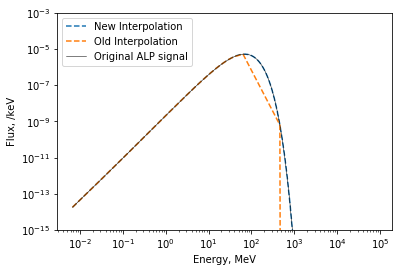

In [6]:
# Careful here! f and f_new interpolate in units /keV. So, here you're plotting 
# x axis in MeV, but your y-axis is in /keV. 

plt.loglog(energy_new, np.exp(f_new(np.log(energy_new * 1000))), ls='--', label="New Interpolation")
plt.loglog(energy, (f(energy*1000)), ls='--', label="Old Interpolation")
plt.loglog(energy_new, sed_new/1000, 'k', lw=0.5, label="Original ALP signal")
plt.legend()
plt.ylim(1e-15, 1e-3)
plt.xlabel('Energy, MeV')
plt.ylabel('Flux, /keV')

In [7]:
# defining the ALP model

def ALP(engs, params, flux):
    energy_binsizes = np.ediff1d(engs)
     # finding the average bin value for energy
    energy1 = np.sqrt(np.asarray(engs[:-1]) * np.asarray(engs[1:])) #(np.asarray(engs[:-1])+np.asarray(engs[1:]))/2
    flux[:] = np.exp(f_new(np.log(energy1)))* (energy_binsizes) 
    
ALPInfo = ()
xs.AllModels.addPyMod(ALP, ALPInfo, 'add', spectrumDependent=False)

In [8]:
# loading the data for the GRB

xs.AllData.clear()
s1 = xs.Spectrum("bn130305486_n6_srcspectra.pha{*}")
s1.response = ("bn130305486_n6_weightedrsp.rsp")
s1.background= ("bn130305486_n6_bkgspectra.bak{1}")
s2 = xs.Spectrum("bn130305486_n9_srcspectra.pha{*}")
s2.response = ("bn130305486_n9_weightedrsp.rsp")
s2.background= ("bn130305486_n9_bkgspectra.bak{1}")
s3 = xs.Spectrum("bn130305486_b1_srcspectra.pha{*}")
s3.response = ("bn130305486_b1_weightedrsp.rsp")
s3.background= ("bn130305486_b1_bkgspectra.bak{1}")
s4 = xs.Spectrum("bn130305486_LAT-LLE_srcspectra.pha{*}")
s4.response = ("bn130305486_LAT-LLE_weightedrsp.rsp")
s4.background= ("bn130305486_LAT-LLE_bkgspectra.bak{1}")

In [9]:
xs.AllModels.clear()
m = xs.Model("ALP")
m.ALP.norm.values=1.
m.ALP.norm.frozen = True
# xs.Fit.perform()

In [10]:
xs.Plot.device="/xs"
xs.Plot.setRebin(3.0,12)
xs.Plot.xAxis="MeV"
xs.Plot.add=True
xs.Plot.background=False
xs.Plot.xLog=True
xs.Plot.yLog=True
xs.Plot("model")
xs.Plot.show()


User entered plot commands:


In [11]:
# checking if ALP normalization is 1 
m.ALP.norm.values[0]

1.0

In [12]:
xValsA_GBM1 = np.asarray(xs.Plot.x(1))
modValsA_GBM1 = np.asarray(xs.Plot.model(1))

xValsA_GBM2 = np.asarray(xs.Plot.x(2))
modValsA_GBM2 = np.asarray(xs.Plot.model(2))

xValsA_BGO = np.asarray(xs.Plot.x(3))
modValsA_BGO = np.asarray(xs.Plot.model(3))

xValsA_LLE = np.asarray(xs.Plot.x(4))
modValsA_LLE = np.asarray(xs.Plot.model(4))

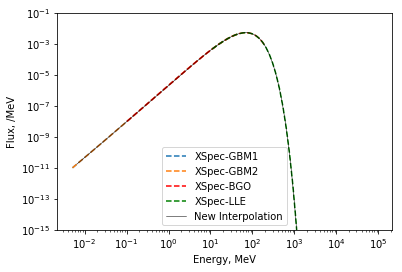

In [13]:
plt.loglog(xValsA_GBM1, np.asarray(modValsA_GBM1), ls='--',label="XSpec-GBM1") # per MeV
plt.loglog(xValsA_GBM1, np.asarray(modValsA_GBM1), ls='--', label="XSpec-GBM2") # per MeV
plt.loglog(xValsA_BGO, np.asarray(modValsA_BGO), ls='--', color='r',label="XSpec-BGO") # per MeV
plt.loglog(xValsA_LLE, np.asarray(modValsA_LLE), ls='--', color = 'g', label="XSpec-LLE") # per MeV
# plt.loglog(energy_new, np.exp(f_new(np.log(energy_new*1000))), ls='-', color = 'k',label="New Interpolation", linewidth = 0.5) # per keV
plt.loglog(energy_new, 1000*np.exp(f_new(np.log(energy_new*1000))), ls='-', color = 'k',label="New Interpolation", linewidth = 0.5) # per MeV
plt.ylim(1e-15, 1e-1)
plt.xlabel('Energy, MeV')
plt.ylabel('Flux, /MeV')
plt.legend()